### Importing Dependencies

In [ ]:
!pip install -q -U tensorflow-addons

In [ ]:
import numpy as np
import math
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.optimizers import SGD
import tensorflow_addons as tfa
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.callbacks import ModelCheckpoint
import random
from keras.layers import Input, Lambda, Dense, Dropout, Flatten

### Train test split

In [ ]:
(x_train, y_train) , (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=55)

#x_train= x_train.reshape(x_train.shape[0], 28, 28, 1)
#x_test = x_test.reshape(x_test.shape[0],28,28,1)
print("Data after 70:30 split")
print("----------------------\n")
print("X_train shape :", x_train.shape)
print("y_train shape :", y_train.shape)
print("X_test shape :", x_test.shape)
print("y_test shape :", y_test.shape)

Data after 70:30 split
----------------------

X_train shape : (49000, 28, 28)
y_train shape : (49000,)
X_test shape : (21000, 28, 28)
y_test shape : (21000,)


### Data Preprocessing

In [ ]:
def normalize_data(x_train, x_test):
    x_train = x_train / 255.0
    x_test = x_test / 255.0
    return x_train, x_test
    
x_train, x_test = normalize_data(x_train, x_test)

In [ ]:
def process_labels(y_train, y_test):
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    return y_train, y_test

#y_train, y_test = process_labels(y_train, y_test)    

In [ ]:
def get_pair(data, index, n):
    pr = []
    lbl = []

    for num in range(0, 10):
        for i in range(0, n-1):
            lbl = lbl + [1,0]
            pr = pr + [[ data[index[num][i]], data[index[num][i+1]] ]]
            rnd = (num + random.randrange(1, 10)) % 10
            pr = pr + [[ data[index[num][i]], data[index[rnd][i]] ]]


    pairs = np.array(pr)
    labels = np.array(lbl)

    return pairs, labels


In [ ]:
def get_min_sample_class(index):
    min_sample = 100000
    for i in range(10):
        if len(index[i])<min_sample:
            min_sample = len(index[i])
    return min_sample

In [ ]:
def map_index(label):
    return [np.where(label==digit)[0] for digit in range(10)]

train_index = map_index(y_train)
test_index = map_index(y_test)

train_n = get_min_sample_class(train_index)
test_n = get_min_sample_class(test_index)

train_pairs, train_labels = get_pair(x_train, train_index, train_n)
test_pairs, test_labels = get_pair(x_test, test_index, test_n)


In [ ]:
print(train_pairs.shape)
print(test_pairs.shape)
print(train_labels.shape)
print(test_labels.shape)

(88840, 2, 28, 28)
(37380, 2, 28, 28)
(88840,)
(37380,)


In [ ]:
train_0 = train_pairs[:, 0]
train_1 = train_pairs[:, 1]
train_pairs = [train_0, train_1]

test_0 = test_pairs[:, 0]
test_1 = test_pairs[:, 1]
test_pairs = [test_0, test_1]

In [ ]:
def plot_epoch_vs_loss(hist):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_facecolor('w')
    ax.grid(b=False)
    ax.plot(hist.history['loss'], color='red')
    ax.plot(hist.history['val_loss'], color ='green')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

### Siamese Network Architecture

In [ ]:
def siamese_network():
    input = Input(shape=(28, 28))
    layer = Flatten()(input)

    layer = Dense(512, activation='relu')(layer)
    layer = Dropout(0.2)(layer)

    layer = Dense(256, activation='relu')(layer)
    layer = Dropout(0.5)(layer)

    layer = Dense(256, activation='relu')(layer)
    layer = Dropout(0.3)(layer)

    layer = Dense(128, activation='relu')(layer)

    layer = keras.layers.Lambda(lambda layer: keras.backend.l2_normalize(layer, axis=1))(layer)    
    return Model(input, layer)

In [ ]:
def get_square_sum(v1, v2):
    sqr_diff = keras.backend.square(v1 - v2)
    sqr_sum = keras.backend.sum(sqr_diff, keepdims=True, axis = 1)
    return sqr_sum


def l2dist(v):
    e = keras.backend.epsilon()
    v1, v2 = v

    sqr_sum = get_square_sum(v1, v2)
    maxm = keras.backend.maximum(sqr_sum, e)

    res = keras.backend.sqrt(maxm)
    return res

In [ ]:
def contrastive_loss(actual, predicted):
    actual = float (actual)
    pred_sqr = float (keras.backend.square(predicted))
    
    maxm = keras.backend.maximum(0.0, 1-predicted)
    mgr_sqr = float (keras.backend.square(maxm))

    a = pred_sqr * actual
    b = mgr_sqr * (1.0-actual)

    loss = keras.backend.mean(a + b)
    return loss

In [ ]:
def accuracy(actual, predicted):
    pred = keras.backend.cast(predicted < 0.5, actual.dtype)
    eql = keras.backend.equal(actual, pred)
    acc = keras.backend.mean(eql)
    return acc

In [ ]:
def get_model():
    left = Input(shape = (28,28))
    right = Input(shape = (28,28))
    architecture = siamese_network()
    model_a = architecture(left)
    model_b = architecture(right)
    dist = keras.layers.Lambda(l2dist)([model_a, model_b])
    return Model([left, right], dist)

# Running for various Losses

### Contrastive loss

In [ ]:
model = get_model()
model.compile(optimizer='RMSProp', loss = contrastive_loss, metrics=[accuracy])
history = model.fit(train_pairs, train_labels, batch_size = 64, epochs = 10, validation_data=(test_pairs, test_labels))

Epoch 1/10
1389/1389 [==============================] - 26s 18ms/step - loss: 0.1620 - accuracy: 0.7488 - val_loss: 0.0498 - val_accuracy: 0.9346
Epoch 2/10
1389/1389 [==============================] - 24s 17ms/step - loss: 0.0473 - accuracy: 0.9436 - val_loss: 0.0331 - val_accuracy: 0.9629
Epoch 3/10
1389/1389 [==============================] - 24s 17ms/step - loss: 0.0298 - accuracy: 0.9677 - val_loss: 0.0259 - val_accuracy: 0.9678
Epoch 4/10
1389/1389 [==============================] - 24s 17ms/step - loss: 0.0214 - accuracy: 0.9747 - val_loss: 0.0255 - val_accuracy: 0.9676
Epoch 5/10
1389/1389 [==============================] - 24s 17ms/step - loss: 0.0185 - accuracy: 0.9778 - val_loss: 0.0240 - val_accuracy: 0.9699
Epoch 6/10
1389/1389 [==============================] - 24s 17ms/step - loss: 0.0168 - accuracy: 0.9796 - val_loss: 0.0223 - val_accuracy: 0.9733
Epoch 7/10
1389/1389 [==============================] - 24s 17ms/step - loss: 0.0132 - accuracy: 0.9841 - val_loss: 0.0228 -

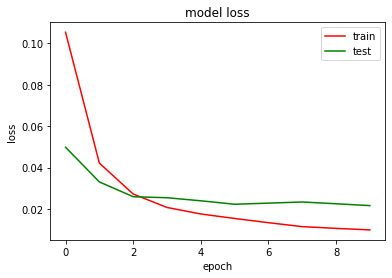

In [ ]:
plot_epoch_vs_loss(history)

### Triplet loss

In [ ]:
model = get_model()
model.compile(optimizer='RMSProp', loss = tfa.losses.TripletSemiHardLoss(), metrics=[accuracy])
history_tripletloss = model.fit(train_pairs, train_labels, batch_size = 64, epochs = 10, validation_data=(test_pairs, test_labels))

Epoch 1/10
1389/1389 [==============================] - 24s 17ms/step - loss: 0.2934 - accuracy: 0.5032 - val_loss: 0.3586 - val_accuracy: 0.5000
Epoch 2/10
1389/1389 [==============================] - 23s 17ms/step - loss: 0.2512 - accuracy: 0.5163 - val_loss: 0.3105 - val_accuracy: 0.5003
Epoch 3/10
1389/1389 [==============================] - 23s 17ms/step - loss: 0.2439 - accuracy: 0.5587 - val_loss: 0.2301 - val_accuracy: 0.6159
Epoch 4/10
1389/1389 [==============================] - 23s 17ms/step - loss: 0.2220 - accuracy: 0.6423 - val_loss: 0.1852 - val_accuracy: 0.7167
Epoch 5/10
1389/1389 [==============================] - 23s 16ms/step - loss: 0.1985 - accuracy: 0.7135 - val_loss: 0.1662 - val_accuracy: 0.7534
Epoch 6/10
1389/1389 [==============================] - 23s 16ms/step - loss: 0.1806 - accuracy: 0.7488 - val_loss: 0.1535 - val_accuracy: 0.7767
Epoch 7/10
1389/1389 [==============================] - 23s 16ms/step - loss: 0.1694 - accuracy: 0.7682 - val_loss: 0.1453 -

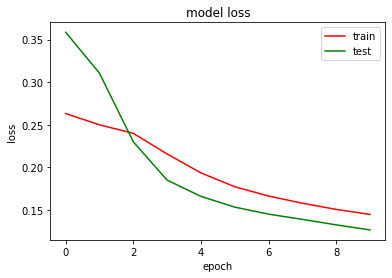

In [ ]:
plot_epoch_vs_loss(history_tripletloss)

### Cross entropy

In [ ]:
model = get_model()
model.compile(optimizer='RMSProp', loss = 'categorical_crossentropy')
history_crossentropy = model.fit(train_pairs, train_labels, batch_size = 64, epochs = 10, validation_data=(test_pairs, test_labels))

Epoch 1/10
1389/1389 [==============================] - 24s 17ms/step - loss: 0.2909 - accuracy: 0.5027 - val_loss: 0.3503 - val_accuracy: 0.5000
Epoch 2/10
1389/1389 [==============================] - 22s 16ms/step - loss: 0.2495 - accuracy: 0.5284 - val_loss: 0.2902 - val_accuracy: 0.5307
Epoch 3/10
1389/1389 [==============================] - 23s 16ms/step - loss: 0.2377 - accuracy: 0.5828 - val_loss: 0.2328 - val_accuracy: 0.6239
Epoch 4/10
1389/1389 [==============================] - 22s 16ms/step - loss: 0.2220 - accuracy: 0.6368 - val_loss: 0.2011 - val_accuracy: 0.6785
Epoch 5/10
1389/1389 [==============================] - 23s 16ms/step - loss: 0.2053 - accuracy: 0.6875 - val_loss: 0.1652 - val_accuracy: 0.7580
Epoch 6/10
1389/1389 [==============================] - 23s 16ms/step - loss: 0.1843 - accuracy: 0.7441 - val_loss: 0.1451 - val_accuracy: 0.7928
Epoch 7/10
1389/1389 [==============================] - 23s 16ms/step - loss: 0.1651 - accuracy: 0.7776 - val_loss: 0.1386 -

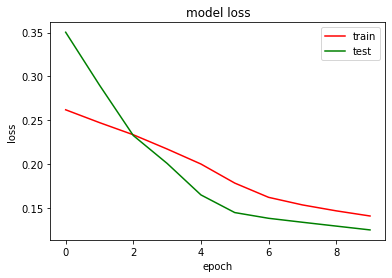

In [ ]:
plot_epoch_vs_loss(history_crossentropy)

# Running for various optimizers 

### 1. RMSProp

In [ ]:
model = get_model()
model.compile(optimizer='RMSProp', loss = contrastive_loss, metrics=[accuracy])
hist_rms = model.fit(train_pairs, train_labels, batch_size = 64, epochs = 10, validation_data=(test_pairs, test_labels))

Epoch 1/10
1389/1389 [==============================] - 29s 20ms/step - loss: 0.1355 - accuracy: 0.8026 - val_loss: 0.0436 - val_accuracy: 0.9436
Epoch 2/10
1389/1389 [==============================] - 27s 20ms/step - loss: 0.0403 - accuracy: 0.9546 - val_loss: 0.0297 - val_accuracy: 0.9636
Epoch 3/10
1389/1389 [==============================] - 27s 20ms/step - loss: 0.0248 - accuracy: 0.9701 - val_loss: 0.0265 - val_accuracy: 0.9675
Epoch 4/10
1389/1389 [==============================] - 28s 20ms/step - loss: 0.0192 - accuracy: 0.9764 - val_loss: 0.0234 - val_accuracy: 0.9704
Epoch 5/10
1389/1389 [==============================] - 28s 20ms/step - loss: 0.0168 - accuracy: 0.9796 - val_loss: 0.0234 - val_accuracy: 0.9713
Epoch 6/10
1389/1389 [==============================] - 28s 20ms/step - loss: 0.0145 - accuracy: 0.9826 - val_loss: 0.0224 - val_accuracy: 0.9733
Epoch 7/10
1389/1389 [==============================] - 28s 20ms/step - loss: 0.0127 - accuracy: 0.9845 - val_loss: 0.0208 -

### 2. ADAM

In [ ]:
model = get_model()
model.compile(optimizer='adam', loss = contrastive_loss, metrics=[accuracy])
hist_adam = model.fit(train_pairs, train_labels, batch_size = 64, epochs = 10, validation_data=(test_pairs, test_labels))

Epoch 1/10
1389/1389 [==============================] - 26s 18ms/step - loss: 0.1537 - accuracy: 0.7634 - val_loss: 0.0485 - val_accuracy: 0.9406
Epoch 2/10
1389/1389 [==============================] - 24s 17ms/step - loss: 0.0463 - accuracy: 0.9487 - val_loss: 0.0335 - val_accuracy: 0.9609
Epoch 3/10
1389/1389 [==============================] - 24s 17ms/step - loss: 0.0271 - accuracy: 0.9698 - val_loss: 0.0260 - val_accuracy: 0.9680
Epoch 4/10
1389/1389 [==============================] - 24s 18ms/step - loss: 0.0206 - accuracy: 0.9754 - val_loss: 0.0232 - val_accuracy: 0.9721
Epoch 5/10
1389/1389 [==============================] - 24s 18ms/step - loss: 0.0171 - accuracy: 0.9799 - val_loss: 0.0231 - val_accuracy: 0.9710
Epoch 6/10
1389/1389 [==============================] - 24s 18ms/step - loss: 0.0149 - accuracy: 0.9828 - val_loss: 0.0224 - val_accuracy: 0.9715
Epoch 7/10
1389/1389 [==============================] - 24s 17ms/step - loss: 0.0123 - accuracy: 0.9855 - val_loss: 0.0231 -

### 3. Mini Batch Gradient Descent

In [ ]:
model = get_model()
model.compile(optimizer='SGD', loss = contrastive_loss, metrics=[accuracy])
hist_sgd = model.fit(train_pairs, train_labels, batch_size = 64, epochs = 10, validation_data=(test_pairs, test_labels))

Epoch 1/10
1389/1389 [==============================] - 27s 19ms/step - loss: 0.2853 - accuracy: 0.5052 - val_loss: 0.3573 - val_accuracy: 0.5000
Epoch 2/10
1389/1389 [==============================] - 24s 17ms/step - loss: 0.2506 - accuracy: 0.5198 - val_loss: 0.2994 - val_accuracy: 0.5206
Epoch 3/10
1389/1389 [==============================] - 24s 17ms/step - loss: 0.2406 - accuracy: 0.5680 - val_loss: 0.2354 - val_accuracy: 0.6291
Epoch 4/10
1389/1389 [==============================] - 24s 17ms/step - loss: 0.2217 - accuracy: 0.6392 - val_loss: 0.2044 - val_accuracy: 0.6877
Epoch 5/10
1389/1389 [==============================] - 24s 17ms/step - loss: 0.2049 - accuracy: 0.6869 - val_loss: 0.1875 - val_accuracy: 0.7180
Epoch 6/10
1389/1389 [==============================] - 24s 17ms/step - loss: 0.1917 - accuracy: 0.7224 - val_loss: 0.1687 - val_accuracy: 0.7567
Epoch 7/10
1389/1389 [==============================] - 24s 17ms/step - loss: 0.1781 - accuracy: 0.7551 - val_loss: 0.1540 -

### Comparision b/w above optimizers

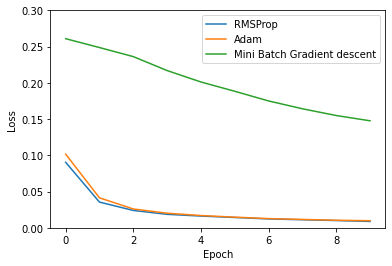

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 0.3])

plt.plot(hist_rms.history['loss'], label='RMSProp')
plt.plot(hist_adam.history['loss'], label='Adam')
plt.plot(hist_sgd.history['loss'], label='Mini Batch Gradient descent') 

plt.legend()

Choosing Adam as a best optimizer because:
1. It is Computationally efficient.
2. Training time is much lesser then other algorithms.
3. Have intuitive interpretation and typically require little tuning.

# Trying Hyperparameters Optimization

1. Exponential Annealing
2. Earlystopping
3. ReduceLr on Pleateau

In [ ]:
def exp_decay(epoch):
   initial_lrate = 0.01
   lrate = initial_lrate * math.exp(-0.1*epoch)
   return lrate

lrt = LearningRateScheduler(exp_decay)

# To prevent over fitting we will stop the learning after 5 epochs and val_loss value not decreased
earlystop = EarlyStopping(patience=5)

# It will reduce the learning rate when accuracy is not increasing for 2 epochs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction, lrt]

In [ ]:
model = get_model()
model.compile(optimizer='Adam', loss = contrastive_loss, metrics=[accuracy])
hist_optimal = model.fit(train_pairs, train_labels, batch_size = 64, epochs = 10, callbacks = callbacks, validation_data=(test_pairs, test_labels))

Epoch 1/10
1389/1389 [==============================] - 48s 34ms/step - loss: 0.1896 - accuracy: 0.6817 - val_loss: 0.0620 - val_accuracy: 0.9269
Epoch 2/10
1389/1389 [==============================] - 33s 23ms/step - loss: 0.0565 - accuracy: 0.9337 - val_loss: 0.0359 - val_accuracy: 0.9536
Epoch 3/10
1389/1389 [==============================] - 35s 25ms/step - loss: 0.0339 - accuracy: 0.9615 - val_loss: 0.0307 - val_accuracy: 0.9615
Epoch 4/10
1389/1389 [==============================] - 34s 25ms/step - loss: 0.0246 - accuracy: 0.9712 - val_loss: 0.0269 - val_accuracy: 0.9660
Epoch 5/10
1389/1389 [==============================] - 31s 22ms/step - loss: 0.0196 - accuracy: 0.9767 - val_loss: 0.0257 - val_accuracy: 0.9686
Epoch 6/10
1389/1389 [==============================] - 34s 25ms/step - loss: 0.0158 - accuracy: 0.9810 - val_loss: 0.0216 - val_accuracy: 0.9742
Epoch 7/10
1389/1389 [==============================] - 33s 24ms/step - loss: 0.0137 - accuracy: 0.9839 - val_loss: 0.0211 -

# Pros And Cons Of Saimese Network

#### Pros :

1. More robust to class imbalance problem.
2. Can be used with very less amount of data.
3. Can be easily ensemble with best classifier.
4. This algorithm learns embeddings the place the objects of same class together.
5. Can also handle varying input requirements.

#### Cons :

1. It takes more training time as compared to other networks.
2. It will not output probabilities (which is required in many cases)